In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.ingest_data import DataIngestorFactory #For Data ingestion
from src.HCPDataPrepare import HCPDataPreparer  #For Data preparation
import re

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [2]:
ingester = DataIngestorFactory.get_data_ingestor('.xlsx')
file_path = r"data\raw\HCP Dataset for Case Study.xlsx"
df = ingester.ingest(file_path)


In [3]:
# Check for missing values
null_check = pd.DataFrame(df.isna().any(), columns=['Null Value Exist']).value_counts()

# Check for duplicate rows
duplicate_check = pd.DataFrame(df.duplicated(), columns=['Duplicate Value Exist']).value_counts()

# Display both in the same cell
print("=== Null Value Check ===")
print(null_check)
print("\n=== Duplicate Value Check ===")
print(duplicate_check)


=== Null Value Check ===
Null Value Exist
False               162
Name: count, dtype: int64

=== Duplicate Value Check ===
Duplicate Value Exist
False                    30615
Name: count, dtype: int64


In [4]:
#Manual Inspection
df.head()

,InsurerIdentifier,EpisodeIdentifier,DateOfBirth,Postcode,Sex,AdmissionDate,SeparationDate,HospitalType,ICU_Days,ICU_Hours,TotalPyschCareDays,DRG,DRG_Version,AdmissionTime,UrgencyOfAdmission,TransferInProviderNumber,CareType,SourceOfReferral,DischargeIntention,InterHospitalContracted,MentalHealthLegalStatus,PalliativeCareStatus,Readmission28Days,UnplannedTheatreVisit,InfantWeight,HoursMechVentilation,ModeOfSeparation,SeparationTime,TotalLeaveDays,TransferOutProviderNumber,NonCertifiedDays,HIH_Days,PrincipalDiagnosis,AdditionalDiagnosis1,AdditionalDiagnosis2,AdditionalDiagnosis3,AdditionalDiagnosis4,AdditionalDiagnosis5,AdditionalDiagnosis6,AdditionalDiagnosis7,AdditionalDiagnosis8,AdditionalDiagnosis9,AdditionalDiagnosis10,AdditionalDiagnosis11,AdditionalDiagnosis12,AdditionalDiagnosis13,AdditionalDiagnosis14,AdditionalDiagnosis15,AdditionalDiagnosis16,AdditionalDiagnosis17,AdditionalDiagnosis18,AdditionalDiagnosis19,AdditionalDiagnosis20,AdditionalDiagnosis21,AdditionalDiagnosis22,AdditionalDiagnosis23,AdditionalDiagnosis24,AdditionalDiagnosis25,AdditionalDiagnosis26,AdditionalDiagnosis27,AdditionalDiagnosis28,AdditionalDiagnosis29,AdditionalDiagnosis30,AdditionalDiagnosis31,AdditionalDiagnosis32,AdditionalDiagnosis33,AdditionalDiagnosis34,AdditionalDiagnosis35,AdditionalDiagnosis36,AdditionalDiagnosis37,AdditionalDiagnosis38,AdditionalDiagnosis39,AdditionalDiagnosis40,AdditionalDiagnosis41,AdditionalDiagnosis42,AdditionalDiagnosis43,AdditionalDiagnosis44,AdditionalDiagnosis45,AdditionalDiagnosis46,AdditionalDiagnosis47,AdditionalDiagnosis48,AdditionalDiagnosis49,Procedure1,Procedure2,Procedure3,Procedure4,Procedure5,Procedure6,Procedure7,Procedure8,Procedure9,Procedure10,Procedure11,Procedure12,Procedure13,Procedure14,Procedure15,Procedure16,Procedure17,Procedure18,Procedure19,Procedure20,Procedure21,Procedure22,Procedure23,Procedure24,Procedure25,Procedure26,Procedure27,Procedure28,Procedure29,Procedure30,Procedure31,Procedure32,Procedure33,Procedure34,Procedure35,Procedure36,Procedure37,Procedure38,Procedure39,Procedure40,Procedure41,Procedure42,Procedure43,Procedure44,Procedure45,Procedure46,Procedure47,Procedure48,Procedure49,Procedure50,SameDayStatus,PrincipalMBS_ItemNumber,PrincipalMBS_ItemDate,TheatreMinutes,SecondaryMBS_ItemNumber1,SecondaryMBS_ItemNumber2,SecondaryMBS_ItemNumber3,SecondaryMBS_ItemNumber4,SecondaryMBS_ItemNumber5,SecondaryMBS_ItemNumber6,SecondaryMBS_ItemNumber7,SecondaryMBS_ItemNumber8,SecondaryMBS_ItemNumber9,AccommodationCharge,TheatreCharge,LabourWardCharge,ICU_Charge,ProsthesisCharge,PharmacyCharge,OtherCharges,BundledCharges,HIH_Charges,SCN_Charges,CCU_Charges,SCN_Hours,CCU_Hours,SCN_Days,CCU_Days,QualifiedDaysNewborns,PalliativeCareDays
0,INS1,1624122,1012000,6280,1,1012023,2012023,2,0,0,0,I30Z,,850,2,,1,8,9,9,9,2,8,2,0,0,9,900,0,,0,0,2S620,2V293,2Y929,2U651,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,4735701,9251419,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,2,47357,1012023,73,,,,,,,,,,10200,0,0,0,72400,0,0,316700,0,0,0,0,0,0,0,0,0
1,INS5,1624177,1011937,6233,2,1012023,6012023,2,0,0,0,E75A,,1330,3,0071120B,1,4,,5,9,2,8,2,0,0,9,1002,0,,0,0,2J22,2J47,2M6250,2D8982,2Z290,2E1165,2Y420,2Y9223,2U739,2U861,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,9627300,9555003,9555009,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,2,,,0,,,,,,,,,,45000,0,0,0,0,0,0,696100,0,0,0,0,0,0,0,0,0
2,INS9,1624113,1011968,6225,2,1012023,9012023,2,0,0,0,I13B,,1155,2,,1,8,9,9,9,2,8,2,0,0,9,1137,0,,0,0,2S8282,2S9343,2X59,2Y929,2U739,2U073,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,4760301,4970900,9251499,9555003,9555009,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,2,47603,6012023,116,49709,,,,,,,,,781300,191700,0,0,206500,0,0,0,0,0,0,0,0,0,0,0,0
3,,1624005,1011955,6281,1,1022023,1022023,2,0,0,0,R63Z,,1037,2,,1,8,9,9,9,2,8,2,0,0,9,1416,0,,0,0,2Z511,2C160,2C797,2C787,2C772,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,9619900,9620900,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1,,,0,,,,,,,,,,47994,0,0,0,0,0,0,0,0,0,0,0,0

In [5]:
##Data Attribute Understanding 
def cluster_columns(df):
    clusters = {
        "Demographics": [],
        "Clinical": [],
        "Financial": [],
        "Provider": [],
        "Care Metrics": [],
        "Other": [],
    }

    for col in df.columns:
        if re.search(r'age|sex|postcode|dob|gender', col, re.IGNORECASE):
            clusters["Demographics"].append(col)
        elif re.search(r'diagnosis|procedure|stay|condition|clinical', col, re.IGNORECASE):
            clusters["Clinical"].append(col)
        elif re.search(r'charge|payment|fee|cost|benefit|fund|gap', col, re.IGNORECASE):
            clusters["Financial"].append(col)
        elif re.search(r'hospital|provider|insurer|identifier', col, re.IGNORECASE):
            clusters["Provider"].append(col)
        elif re.search(r'days|icu|rehab|palliative', col, re.IGNORECASE):
            clusters["Care Metrics"].append(col)
        else:
            clusters["Other"].append(col)

    return clusters

column_clusters = cluster_columns(df)

# Print summary
for cluster, cols in column_clusters.items():
    print(f"\n🔹 {cluster} ({len(cols)} columns):\n{cols[:5]}{'...' if len(cols) > 5 else ''}")



🔹 Demographics (2 columns):
['Postcode', 'Sex']

🔹 Clinical (100 columns):
['PrincipalDiagnosis', 'AdditionalDiagnosis1', 'AdditionalDiagnosis2', 'AdditionalDiagnosis3', 'AdditionalDiagnosis4']...

🔹 Financial (12 columns):
['DischargeIntention', 'AccommodationCharge', 'TheatreCharge', 'LabourWardCharge', 'ICU_Charge']...

🔹 Provider (6 columns):
['InsurerIdentifier', 'EpisodeIdentifier', 'HospitalType', 'TransferInProviderNumber', 'InterHospitalContracted']...

🔹 Care Metrics (13 columns):
['ICU_Days', 'ICU_Hours', 'TotalPyschCareDays', 'PalliativeCareStatus', 'Readmission28Days']...

🔹 Other (29 columns):
['DateOfBirth', 'AdmissionDate', 'SeparationDate', 'DRG', 'DRG_Version']...


### Data Prepare

In [ ]:
# Data Prepare
df_raw = df.copy()
# Prepare the data using the HCPDataPreparer
data_preparer = HCPDataPreparer(df_raw)
df_prepared = data_preparer.prepare_data()
print("\n--- Final Dataset Ready for Analysis ---")
print("The data has been prepared with all the necessary fields to calculate the KPIs.")
print("\nDataFrame Info:")
df_prepared.info()

In [7]:
df_prepared.head()

,insureridentifier,episodeidentifier,dateofbirth,postcode,sex,admissiondate,separationdate,hospitaltype,icu_days,icu_hours,totalpyschcaredays,drg,drg_version,admissiontime,urgencyofadmission,transferinprovidernumber,caretype,sourceofreferral,dischargeintention,interhospitalcontracted,mentalhealthlegalstatus,palliativecarestatus,readmission28days,unplannedtheatrevisit,infantweight,hoursmechventilation,modeofseparation,separationtime,totalleavedays,transferoutprovidernumber,noncertifieddays,hih_days,principaldiagnosis,additionaldiagnosis1,additionaldiagnosis2,additionaldiagnosis3,additionaldiagnosis4,additionaldiagnosis5,additionaldiagnosis6,additionaldiagnosis7,additionaldiagnosis8,additionaldiagnosis9,additionaldiagnosis10,additionaldiagnosis11,additionaldiagnosis12,additionaldiagnosis13,additionaldiagnosis14,additionaldiagnosis15,additionaldiagnosis16,additionaldiagnosis17,additionaldiagnosis18,additionaldiagnosis19,additionaldiagnosis20,additionaldiagnosis21,additionaldiagnosis22,additionaldiagnosis23,additionaldiagnosis24,additionaldiagnosis25,additionaldiagnosis26,additionaldiagnosis27,additionaldiagnosis28,additionaldiagnosis29,additionaldiagnosis30,additionaldiagnosis31,additionaldiagnosis32,additionaldiagnosis33,additionaldiagnosis34,additionaldiagnosis35,additionaldiagnosis36,additionaldiagnosis37,additionaldiagnosis38,additionaldiagnosis39,additionaldiagnosis40,additionaldiagnosis41,additionaldiagnosis42,additionaldiagnosis43,additionaldiagnosis44,additionaldiagnosis45,additionaldiagnosis46,additionaldiagnosis47,additionaldiagnosis48,additionaldiagnosis49,procedure1,procedure2,procedure3,procedure4,procedure5,procedure6,procedure7,procedure8,procedure9,procedure10,procedure11,procedure12,procedure13,procedure14,procedure15,procedure16,procedure17,procedure18,procedure19,procedure20,procedure21,procedure22,procedure23,procedure24,procedure25,procedure26,procedure27,procedure28,procedure29,procedure30,procedure31,procedure32,procedure33,procedure34,procedure35,procedure36,procedure37,procedure38,procedure39,procedure40,procedure41,procedure42,procedure43,procedure44,procedure45,procedure46,procedure47,procedure48,procedure49,procedure50,samedaystatus,principalmbs_itemnumber,principalmbs_itemdate,theatreminutes,secondarymbs_itemnumber1,secondarymbs_itemnumber2,secondarymbs_itemnumber3,secondarymbs_itemnumber4,secondarymbs_itemnumber5,secondarymbs_itemnumber6,secondarymbs_itemnumber7,secondarymbs_itemnumber8,secondarymbs_itemnumber9,accommodationcharge,theatrecharge,labourwardcharge,icu_charge,prosthesischarge,pharmacycharge,othercharges,bundledcharges,hih_charges,scn_charges,ccu_charges,scn_hours,ccu_hours,scn_days,ccu_days,qualifieddaysnewborns,palliativecaredays,admissiondate_dt,admissiondate_yyyymmdd,dateofbirth_dt,dateofbirth_yyyymmdd,separationdate_dt,separationdate_yyyymmdd,totalhospitalcharges,benefitpaid,outofpocketexpense,outofpocketpct,comorbiditycount,admissionyear,admissionmonth,admissiondayofweek,admissiondateonly,lengthofstay,age,principaldiagnosiscode,urgency_mapped,admission_day_name,separation_day_name
0,INS1,1624122,1012000,6280,1,1012023,2012023,2,0,0,0,I30Z,,850,2,,1,8,9,9,9,2,8,2,0,0,9,900,0,,0,0,2S620,2V293,2Y929,2U651,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,4735701,9251419,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,2,47357,1012023,73,,,,,,,,,,10200,0,0,0,72400,0,0,316700,0,0,0,0,0,0,0,0,0,2023-01-01,20230101,2000-01-01,20000101,2023-01-02,20230102,82600,316700,-234100,-283.414044,3,2023,1,Sunday,2023-01-01,1,25,S,Elective,Sunday,Monday
1,INS5,1624177,1011937,6233,2,1012023,6012023,2,0,0,0,E75A,,1330,3,0071120B,1,4,,5,9,2,8,2,0,0,9,1002,0,,0,0,2J22,2J47,2M6250,2D8982,2Z290,2E1165,2Y420,2Y9223,2U739,2U861,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,9627300,9555003,9555009,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,2,,,0,,,,,,,,,,45000,0,0,0,0,0,0,696100,0,0,0,0,0,0,0,0,0,2023-01-01,20230101,1937-01-01,19370101,2023-01-06,20230106,45000,696100,-651100,-1446.888889,9,2023,1,Sunday,2023-01-01

In [8]:
df_grouped_total_charge = (
    df_prepared.groupby('principaldiagnosis', as_index=False)['totalhospitalcharges']
    .sum()
    .sort_values('totalhospitalcharges', ascending=False)
    .head(10)
).reset_index(drop = True)

df_grouped_total_charge['totalhospitalcharges_million'] = df_grouped_total_charge['totalhospitalcharges'] / 1_000_000


In [9]:
# Define theme colors (using hex codes for precision if you want exact matches)
st_john_orange = "#F26522" 
st_john_light_blue = "#6FC3D4"
st_john_dark_blue_text = "#002060" 

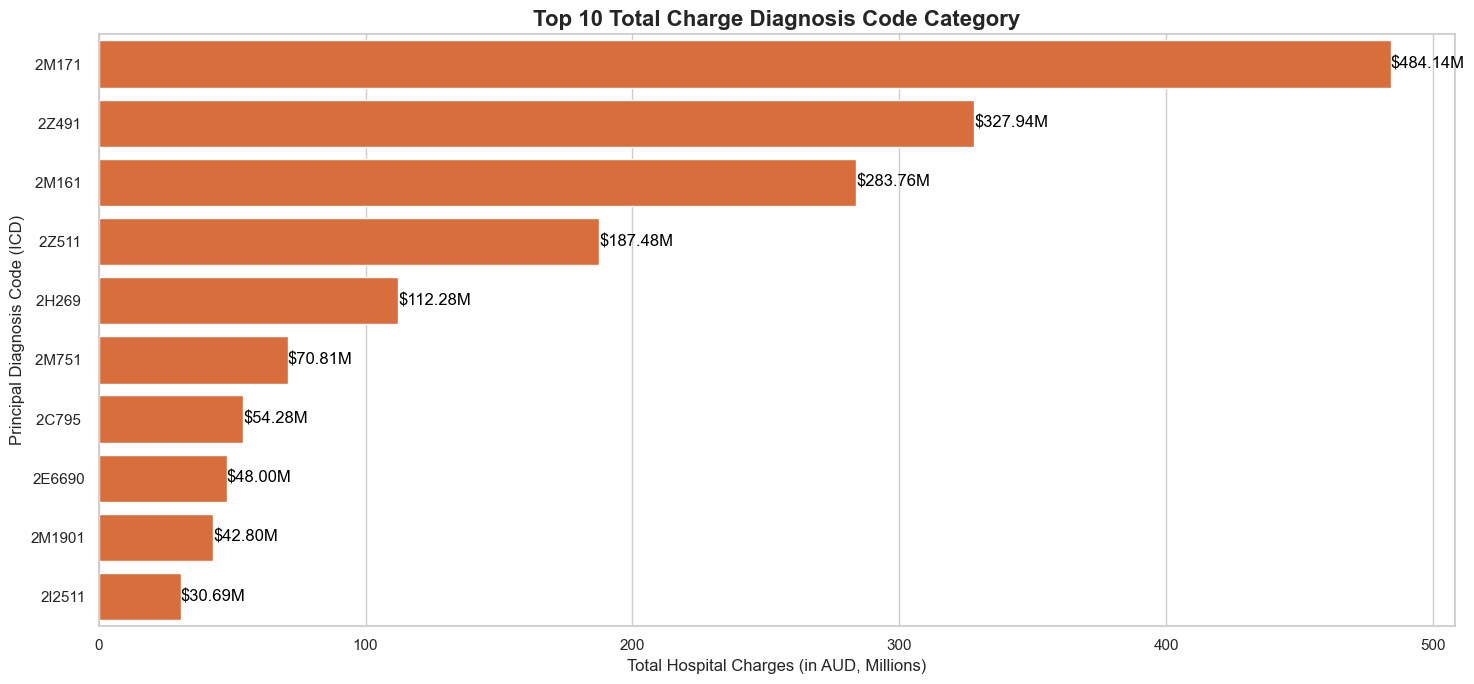

In [10]:
# Set up plot
plt.figure(figsize=(15, 7))
sns.set_theme(style="whitegrid")

plt.title("Top 10 Total Charge Diagnosis Code Category", fontsize=16, weight='bold')
plt.xlabel("Total Hospital Charges (in AUD, Millions)")
plt.ylabel("Principal Diagnosis Code (ICD)")


# Plot with converted values
ax = sns.barplot(
    data=df_grouped_total_charge,
    y='principaldiagnosis',
    x='totalhospitalcharges_million',
    color=st_john_orange
)

# Add value labels in $XM format
for i, (value, label) in enumerate(zip(df_grouped_total_charge['totalhospitalcharges_million'], df_grouped_total_charge['principaldiagnosis'])):
    ax.text(value + 0.02, i, f"${value:.2f}M", color='black', va='center')

plt.tight_layout()
plt.show()

In [11]:
df_grouped_outofpocket = (
    df_prepared.groupby('principaldiagnosis', as_index=False)['outofpocketexpense']
    .sum()
    .sort_values('outofpocketexpense', ascending=False)
    .head(10)
).reset_index(drop = True)

df_grouped_outofpocket['outofpocketexpense_million'] = df_grouped_outofpocket['outofpocketexpense'] / 1_000_000


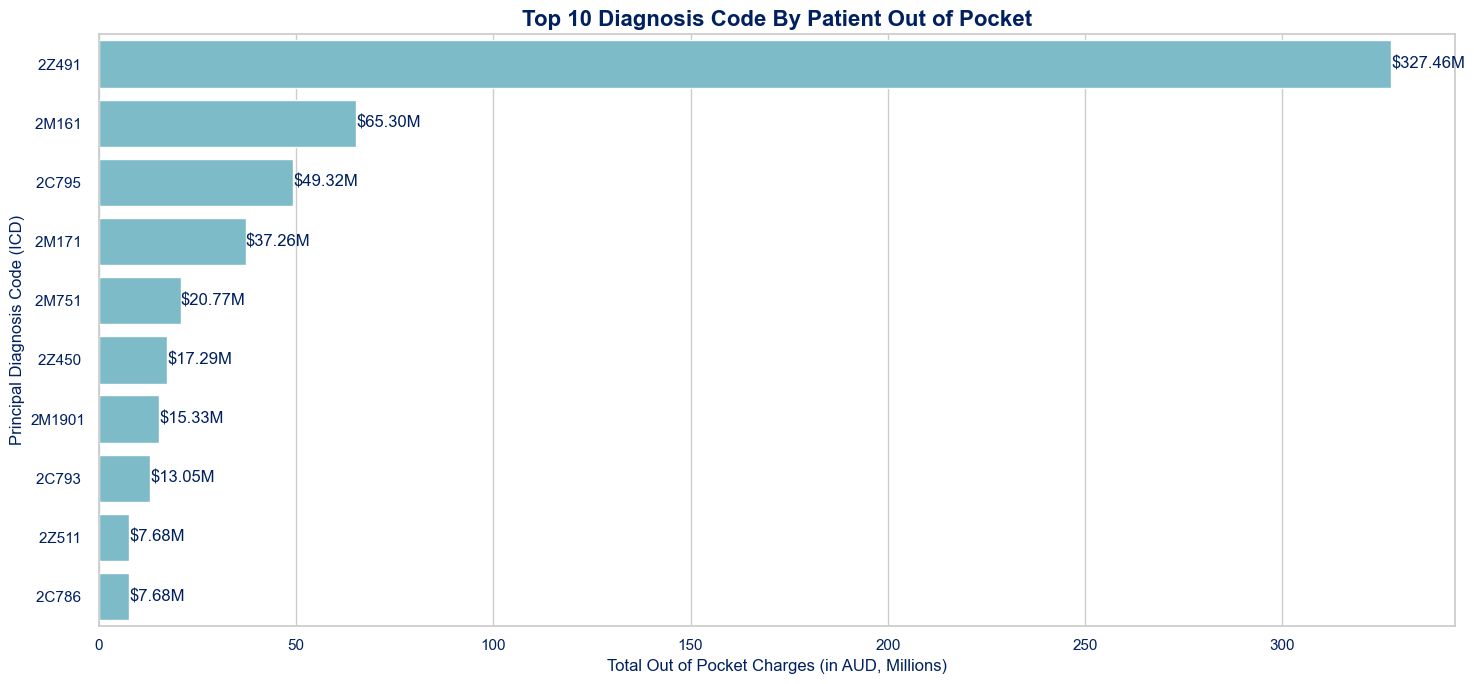

In [12]:
# Set up plot
plt.figure(figsize=(15, 7))
sns.set_theme(style="whitegrid") # Keeping whitegrid as it complements the white background

plt.title("Top 10 Diagnosis Code By Patient Out of Pocket", fontsize=16, weight='bold')
plt.xlabel("Total Out of Pocket Charges (in AUD, Millions)")
plt.ylabel("Principal Diagnosis Code (ICD)")

# Plot with converted values
ax = sns.barplot(
    data=df_grouped_outofpocket,
    y='principaldiagnosis',
    x='outofpocketexpense_million',
    color=st_john_light_blue # Use the orange for the bars
)

# You can also customize the text colors for titles/labels to match the theme
plt.title("Top 10 Diagnosis Code By Patient Out of Pocket", fontsize=16, weight='bold', color=st_john_dark_blue_text)
plt.xlabel("Total Out of Pocket Charges (in AUD, Millions)", color=st_john_dark_blue_text)
plt.ylabel("Principal Diagnosis Code (ICD)", color=st_john_dark_blue_text)

# Customize tick label colors if desired
ax.tick_params(axis='x', colors=st_john_dark_blue_text)
ax.tick_params(axis='y', colors=st_john_dark_blue_text)


# Add value labels in $XM format
for i, (value, label) in enumerate(zip(df_grouped_outofpocket['outofpocketexpense_million'], df_grouped_outofpocket['principaldiagnosis'])):
    ax.text(value + 0.02, i, f"${value:.2f}M", color=st_john_dark_blue_text, va='center') # Use a dark color for readability

plt.tight_layout()
plt.show()

In [13]:
df_grouped_outofpocket_diagnosis = (
    df_prepared.groupby('principaldiagnosiscode', as_index=False)['outofpocketexpense']
    .sum()
    .sort_values('outofpocketexpense', ascending=False)
    .head(10)
).reset_index(drop = True)

df_grouped_outofpocket_diagnosis['outofpocketexpense_million'] = df_grouped_outofpocket_diagnosis['outofpocketexpense'] / 1_000_000

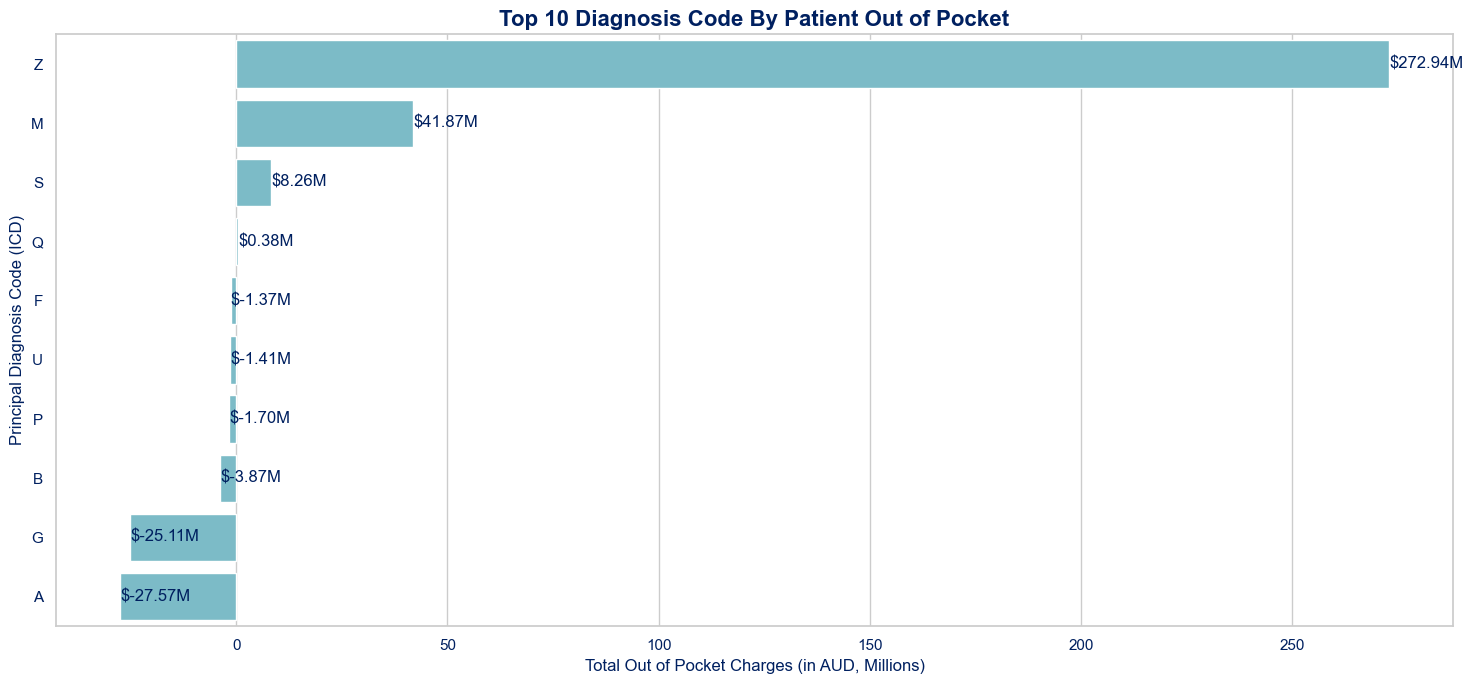

In [14]:
# Set up plot
plt.figure(figsize=(15, 7))
sns.set_theme(style="whitegrid") # Keeping whitegrid as it complements the white background

plt.title("Top 10 Diagnosis Code By Category By Patient Out of Pocket", fontsize=16, weight='bold')
plt.xlabel("Total Out of Pocket Charges (in AUD, Millions)")
plt.ylabel("Principal Diagnosis Code (ICD)")

# Plot with converted values
ax = sns.barplot(
    data=df_grouped_outofpocket_diagnosis,
    y='principaldiagnosiscode',
    x='outofpocketexpense_million',
    color=st_john_light_blue # Use the orange for the bars
)

# You can also customize the text colors for titles/labels to match the theme
plt.title("Top 10 Diagnosis Code By Patient Out of Pocket", fontsize=16, weight='bold', color=st_john_dark_blue_text)
plt.xlabel("Total Out of Pocket Charges (in AUD, Millions)", color=st_john_dark_blue_text)
plt.ylabel("Principal Diagnosis Code (ICD)", color=st_john_dark_blue_text)

# Customize tick label colors if desired
ax.tick_params(axis='x', colors=st_john_dark_blue_text)
ax.tick_params(axis='y', colors=st_john_dark_blue_text)


# Add value labels in $XM format
for i, (value, label) in enumerate(zip(df_grouped_outofpocket_diagnosis['outofpocketexpense_million'], df_grouped_outofpocket_diagnosis['principaldiagnosiscode'])):
    ax.text(value + 0.02, i, f"${value:.2f}M", color=st_john_dark_blue_text, va='center') # Use a dark color for readability

plt.tight_layout()
plt.show()

In [15]:
df_grouped_los = (
    df_prepared.groupby('principaldiagnosiscode', as_index=False)['lengthofstay']
    .mean()
    .sort_values('lengthofstay', ascending=False)
    .head(10)
).reset_index(drop = True)

df_grouped_los['lengthofstay'] = df_grouped_los['lengthofstay'].round(0).astype(int)


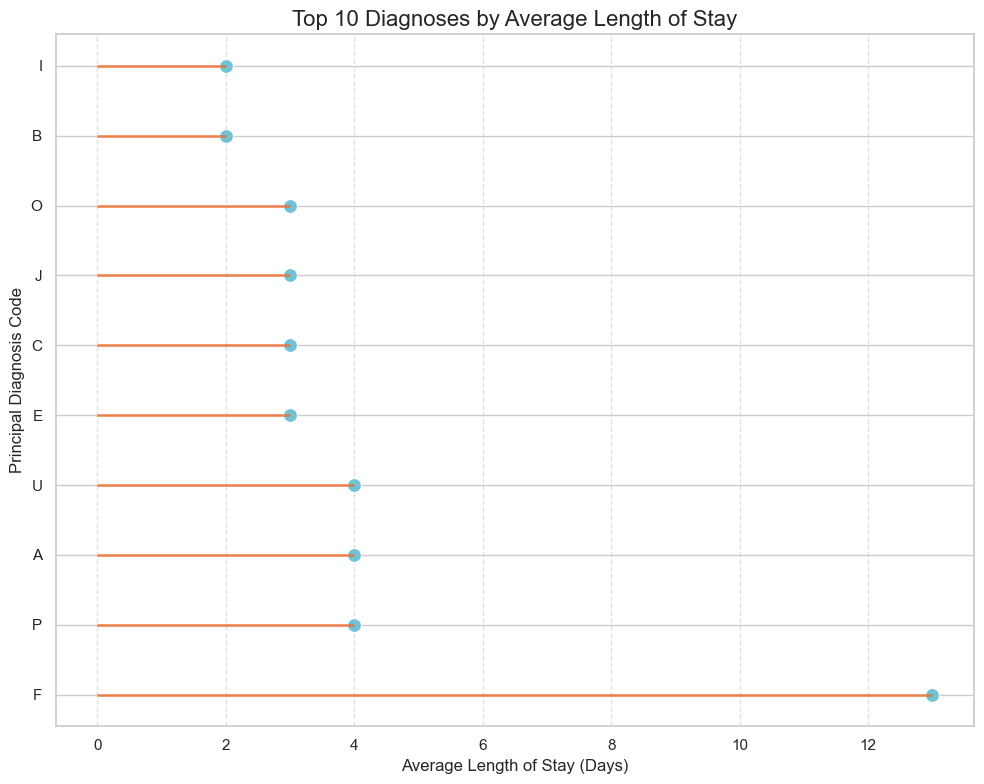

In [16]:
# Sort to ensure descending orde
df_sorted = df_grouped_los.sort_values('lengthofstay', ascending=True)

plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

# Create the plot
ax = plt.gca()

# Add stems (hlines)
for index, row in df_sorted.iterrows():
    ax.hlines(y=row['principaldiagnosiscode'], xmin=0, xmax=row['lengthofstay'], color=st_john_orange, alpha=0.7, linewidth=2)

# Add dots (heads)
sns.scatterplot(
    x='lengthofstay',
    y='principaldiagnosiscode',
    data=df_sorted,
    color=st_john_light_blue,
    s=100,
    ax=ax
)

# Titles and labels
plt.title('Top 10 Diagnoses by Average Length of Stay', fontsize=16)
plt.xlabel('Average Length of Stay (Days)', fontsize=12)
plt.ylabel('Principal Diagnosis Code', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

C:\Users\laaro\AppData\Local\Temp\ipykernel_47836\1870160444.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = df_prepared.pivot_table(


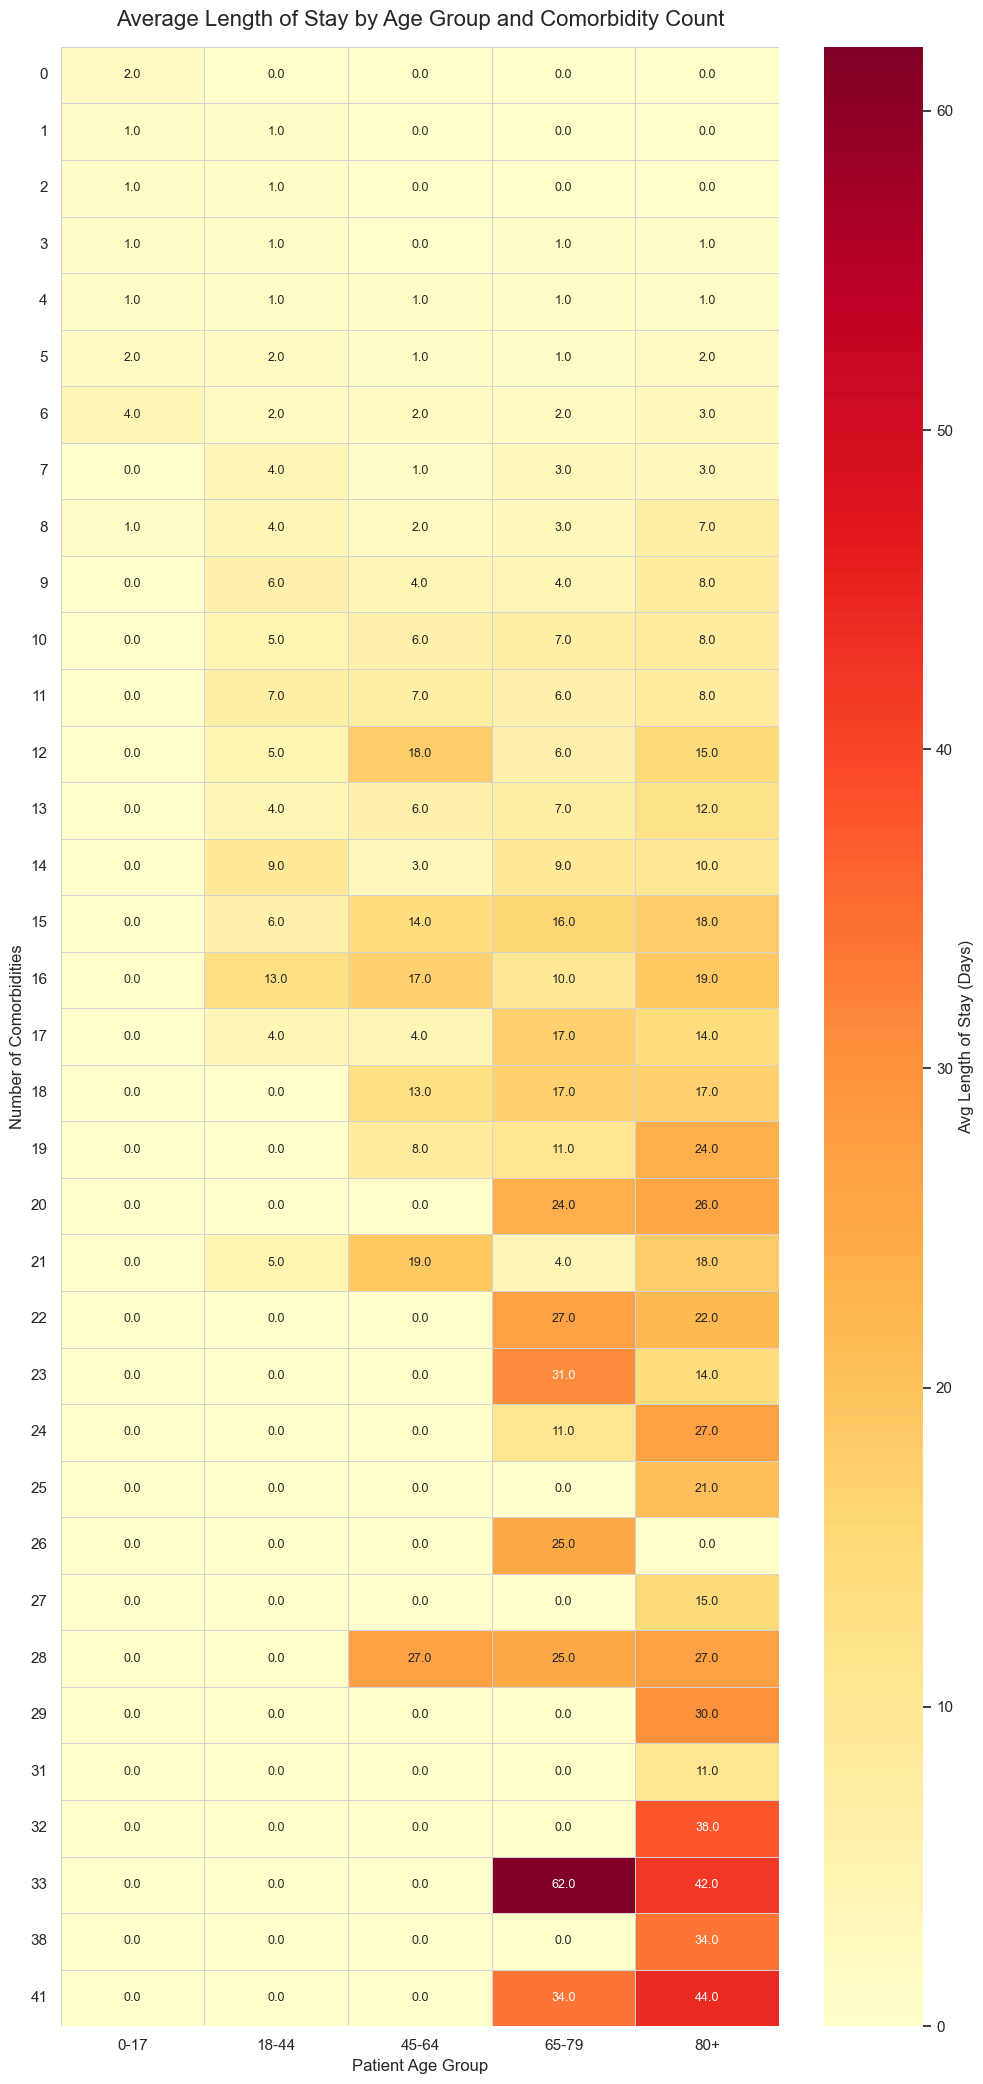

In [17]:
age_labels = ['0-17', '18-44', '45-64', '65-79', '80+']
age_bins = [0, 18, 45, 65, 80, 110]
df_prepared['age_group'] = pd.cut(df_prepared['age'], bins=age_bins, labels=age_labels, right=False)

heatmap_data = df_prepared.pivot_table(
    values='lengthofstay',
    index='comorbiditycount',
    columns='age_group',
    aggfunc='mean'
)

heatmap_data = heatmap_data.fillna(0)[age_labels]
heatmap_data = heatmap_data.round(0)


num_rows = heatmap_data.shape[0]
fig_height = max(6, num_rows * 0.6)  # Adjust height per row with a minimum

plt.figure(figsize=(10, fig_height)) 
sns.set_theme(style="white")

ax = sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".1f",
    linewidths=0.5,
    cmap="YlOrRd",
    cbar_kws={"label": "Avg Length of Stay (Days)"},
    linecolor='lightgrey',
    annot_kws={"size": 9},
    square=False
)

# Titles and labels
plt.title('Average Length of Stay by Age Group and Comorbidity Count', fontsize=16, pad=15)
plt.xlabel('Patient Age Group', fontsize=12)
plt.ylabel('Number of Comorbidities', fontsize=12)

plt.xticks(rotation=0)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()


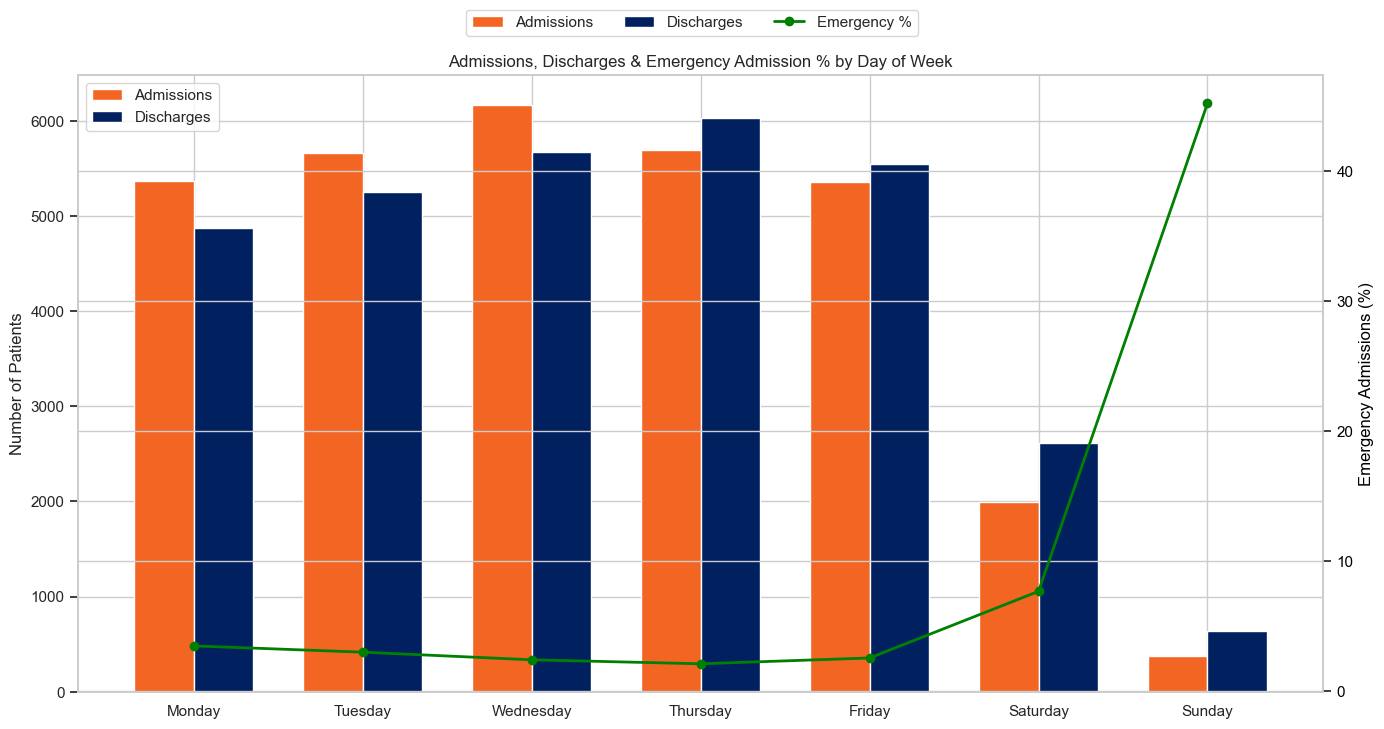

In [18]:

# Define day order
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create daily counts
admissions = df_prepared['admission_day_name'].value_counts().reindex(days_order)
discharges = df_prepared['separation_day_name'].value_counts().reindex(days_order)

# Emergency % by day
urgency_counts = df_prepared.groupby(['admission_day_name', 'urgency_mapped']).size().unstack(fill_value=0).reindex(days_order)
urgency_counts['Total'] = urgency_counts.sum(axis=1)
urgency_counts['EmergencyPct'] = (urgency_counts['Emergency'] / urgency_counts['Total']) * 100

# Plotting
sns.set(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(14, 7))

# Bar plots for admissions and discharges
width = 0.35
x = range(len(days_order))
ax1.bar([i - width/2 for i in x], admissions, width=width, label='Admissions', color="#F26522")
ax1.bar([i + width/2 for i in x], discharges, width=width, label='Discharges', color="#002060")
ax1.set_ylabel("Number of Patients")
ax1.set_xticks(x)
ax1.set_xticklabels(days_order)
ax1.legend(loc="upper left")

# Line plot for emergency %
ax2 = ax1.twinx()
ax2.plot(x, urgency_counts['EmergencyPct'], color='green', marker='o', linewidth=2, label='Emergency %')
ax2.set_ylabel("Emergency Admissions (%)", color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Title and legend
plt.title("Admissions, Discharges & Emergency Admission % by Day of Week")
fig.tight_layout()
fig.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.05))

plt.show()
